In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
from sklearn.preprocessing import StandardScaler
# Fix font warnings by using bundled DejaVu Sans
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']
mpl.rcParams['axes.unicode_minus'] = False
flag = True  # Set this flag as needed
name = "Preprocessed_Data.csv" if flag == True else "Mall_Customers.csv"
df = pd.read_csv(name)
if name == "Mall_Customers.csv":
    df = df.drop(columns=['CustomerID'])
    df['Genre'] = df['Genre'].map({'Male': 1, 'Female': 0})
    ss = StandardScaler()
    df[ df.columns ] = ss.fit_transform( df[ df.columns ] )
df.head()

,Annual Income (k$),Genre,Income_per_Age,Spend_to_Income,Spending Score (1-100)
0,-1.866777,1.163468,-1.137799,4.430747,1.190104
1,-1.825592,-0.859499,-1.158515,3.828132,1.032512
2,-1.784407,-0.859499,-1.322240,1.305295,-0.425212
3,-1.784407,-0.859499,-1.072825,3.477424,0.993114
4,-1.743222,-0.859499,-1.360152,-0.766272,-1.764743


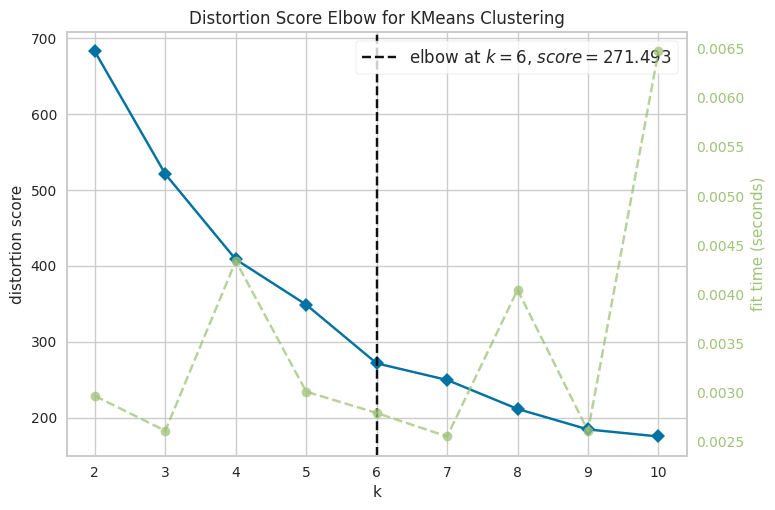

,estimator,KMeans(n_clus...ndom_state=42)
,ax,<Axes: title=...ortion score'>
,k,"(2, ...)"
,metric,'distortion'
,distance_metric,'euclidean'
,timings,True
,locate_elbow,True
,n_clusters,10
,init,'k-means++'
,n_init,'auto'
,max_iter,300


In [89]:
# 肘部法：使用平均簇内欧氏距离而非 inertia
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.manifold import TSNE
X_scaled = df.copy()
# K = range(1, 11)
# avg_within_dist = []
# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     labels = kmeans.fit_predict(X_scaled)
#     centroids = kmeans.cluster_centers_
#     # 每个样本到其簇质心的欧氏距离
#     dists = np.linalg.norm(X_scaled - centroids[labels], axis=1)
#     avg_within_dist.append(dists.mean())
# plt.figure(figsize=(8, 4))
# plt.plot(K, avg_within_dist, 'bx-')
# plt.xlabel('Number of clusters')
# plt.ylabel('Average within-cluster Euclidean distance')
# plt.title('Elbow Method (Distance-Based)')
# plt.show()
kelbow_visualizer(KMeans(random_state=42), X_scaled, k=(2,11))

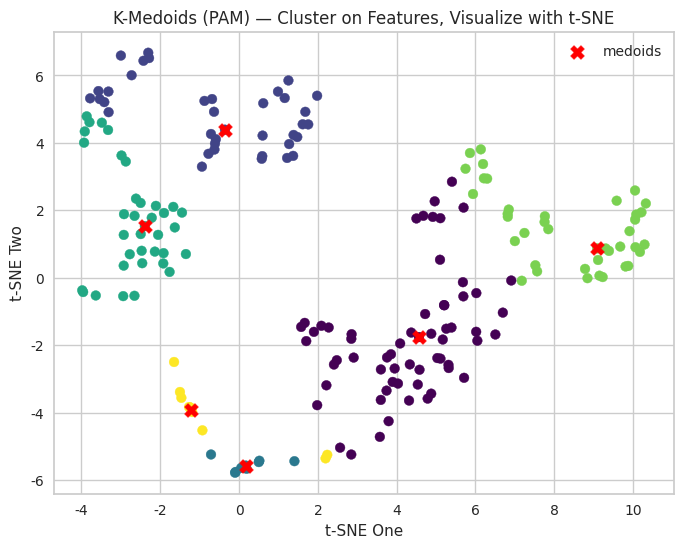

In [90]:
# clustering by k-medoids (PAM) - pure-Python implementation to avoid sklearn_extra binary dependency
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def kmedoids_pam(X, n_clusters, max_iter=500, n_init=5, tol=1e-6, random_state=42):
    """PAM (Partitioning Around Medoids) with KMeans++-style init,
    multiple initializations, empty-cluster handling, and early stopping."""
    rng_main = np.random.default_rng(random_state)
    n_samples = X.shape[0]
    # full pairwise distance matrix (Euclidean)
    D = pairwise_distances(X, metric='euclidean')

    def init_medoids_kpp(D, k, rng):
        n = D.shape[0]
        medoids = []
        first = int(rng.integers(0, n))
        medoids.append(first)
        for _ in range(1, k):
            dist_to_nearest = np.min(D[:, medoids], axis=1)
            probs = dist_to_nearest ** 2
            total = probs.sum()
            if total <= 0:
                candidates = [i for i in range(n) if i not in medoids]
                next_medoid = int(rng.choice(candidates)) if candidates else medoids[-1]
            else:
                probs = probs / total
                probs[medoids] = 0.0
                psum = probs.sum()
                if psum <= 0:
                    candidates = [i for i in range(n) if i not in medoids]
                    next_medoid = int(rng.choice(candidates)) if candidates else medoids[-1]
                else:
                    next_medoid = int(rng.choice(n, p=probs))
            medoids.append(next_medoid)
        return np.array(medoids, dtype=int)

    def total_cost(D, medoids):
        return float(np.min(D[:, medoids], axis=1).sum())

    def pam_run(rng):
        medoids = init_medoids_kpp(D, n_clusters, rng)
        labels = np.argmin(D[:, medoids], axis=1)
        prev_cost = total_cost(D, medoids)
        for _ in range(max_iter):
            changed = False
            # update step: set medoid in each cluster to point minimizing intra-cluster distance
            for i in range(n_clusters):
                cluster_idx = np.where(labels == i)[0]
                if len(cluster_idx) == 0:
                    continue
                subD = D[np.ix_(cluster_idx, cluster_idx)]
                costs = subD.sum(axis=1)
                new_medoid_local = cluster_idx[int(np.argmin(costs))]
                if new_medoid_local != medoids[i]:
                    medoids[i] = new_medoid_local
                    changed = True
            # assign step
            labels = np.argmin(D[:, medoids], axis=1)
            # handle empty clusters by reassigning medoid to farthest point
            for i in range(n_clusters):
                if not np.any(labels == i):
                    dist_to_nearest = np.min(D[:, medoids], axis=1)
                    new_m = int(np.argmax(dist_to_nearest))
                    medoids[i] = new_m
                    changed = True
                    labels = np.argmin(D[:, medoids], axis=1)
            cur_cost = total_cost(D, medoids)
            if not changed or abs(prev_cost - cur_cost) < tol:
                break
            prev_cost = cur_cost
        return medoids, labels, prev_cost

    best_cost = np.inf
    best_medoids, best_labels = None, None
    seeds = rng_main.integers(0, 1_000_000_000, size=max(1, n_init))
    for s in seeds:
        rng = np.random.default_rng(int(s))
        medoids, labels, cost = pam_run(rng)
        if cost < best_cost:
            best_cost, best_medoids, best_labels = cost, medoids, labels
    return best_medoids, best_labels

# Cluster first on original (scaled) features, then visualize via t-SNE
data_kmedoids = df.copy()  # already preprocessed
kmedoids_n = 6
X_scaled = data_kmedoids.copy()
medoids, labels = kmedoids_pam(X_scaled, n_clusters=kmedoids_n, n_init=5, random_state=42)
# t-SNE for visualization only
n = X_scaled.shape[0]
perplexity = int(np.clip(n // 3 - 1, 5, 50))
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)
data_kmedoids['tsne-one'] = tsne_result[:, 0]
data_kmedoids['tsne-two'] = tsne_result[:, 1]
data_kmedoids['kmedoids_cluster'] = labels
plt.figure(figsize=(8, 6))
plt.scatter(data_kmedoids['tsne-one'], data_kmedoids['tsne-two'], c=data_kmedoids['kmedoids_cluster'], cmap='viridis')
# mark medoids on the t-SNE plot using sample indices
plt.scatter(tsne_result[medoids, 0], tsne_result[medoids, 1], c='red', marker='X', s=100, label='medoids')
plt.title('K-Medoids (PAM) — Cluster on Features, Visualize with t-SNE')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.legend()
plt.show()

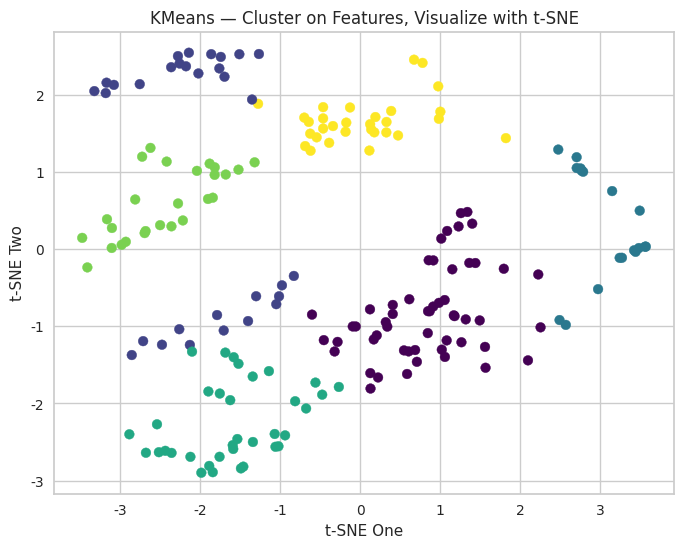

In [97]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

data_kmeans = df.copy()  # already preprocessed
# Cluster on scaled original features
X_scaled = data_kmeans.copy()
kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(X_scaled)
# Visualize with t-SNE only
tsne = TSNE(n_components=2, perplexity=100, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)
data_kmeans['tsne-one'] = tsne_result[:, 0]
data_kmeans['tsne-two'] = tsne_result[:, 1]
data_kmeans['cluster'] = labels
plt.figure(figsize=(8,6))
plt.scatter(data_kmeans['tsne-one'], data_kmeans['tsne-two'], c=data_kmeans['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('KMeans — Cluster on Features, Visualize with t-SNE')
plt.show()

/tmp/ipykernel_30799/1727453377.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


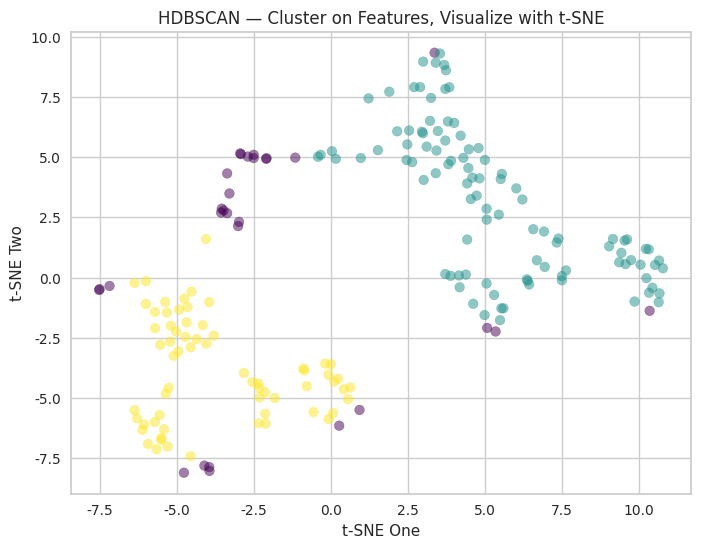

In [92]:
from sklearn.cluster import HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

data_hdbscan = df.copy()  # already preprocessed
# Cluster on scaled original features
X_scaled = data_hdbscan.copy()
hdbscan_model = HDBSCAN(min_cluster_size=15)
labels = hdbscan_model.fit_predict(X_scaled)
# Visualize with t-SNE only
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_result_hdbscan = tsne.fit_transform(X_scaled)
data_hdbscan['tsne-one'] = tsne_result_hdbscan[:, 0]
data_hdbscan['tsne-two'] = tsne_result_hdbscan[:, 1]
data_hdbscan['cluster'] = labels
plt.figure(figsize=(8,6))
plt.scatter(data_hdbscan['tsne-one'], data_hdbscan['tsne-two'], alpha=0.5, c=data_hdbscan['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('HDBSCAN — Cluster on Features, Visualize with t-SNE')
plt.legend()
plt.show()

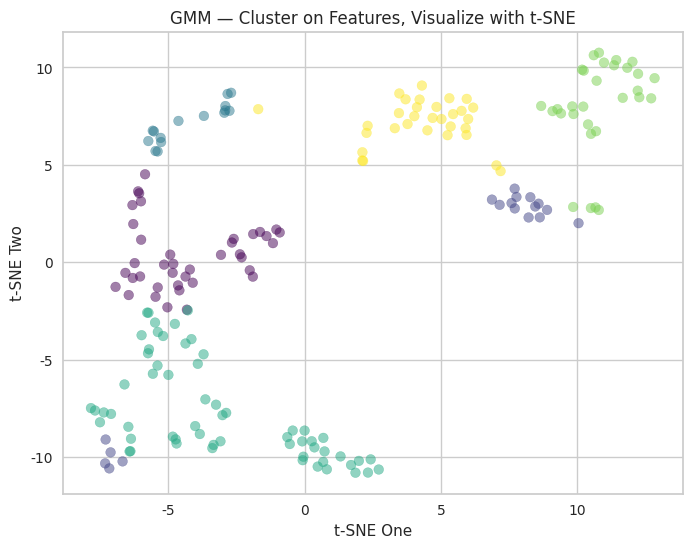

In [98]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

data_gmm = df.copy()  # already preprocessed
# Cluster on scaled original features
X_scaled = data_gmm.copy()
gmm = GaussianMixture(n_components=6, random_state=42)
labels = gmm.fit_predict(X_scaled)
# Visualize with t-SNE only
tsne = TSNE(n_components=2, random_state=42)
tsne_result_gmm = tsne.fit_transform(X_scaled)
data_gmm['tsne-one'] = tsne_result_gmm[:, 0]
data_gmm['tsne-two'] = tsne_result_gmm[:, 1]
data_gmm['cluster'] = labels
plt.figure(figsize=(8,6))
plt.scatter(data_gmm['tsne-one'], data_gmm['tsne-two'], alpha=0.5, c=data_gmm['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('GMM — Cluster on Features, Visualize with t-SNE')
plt.show()

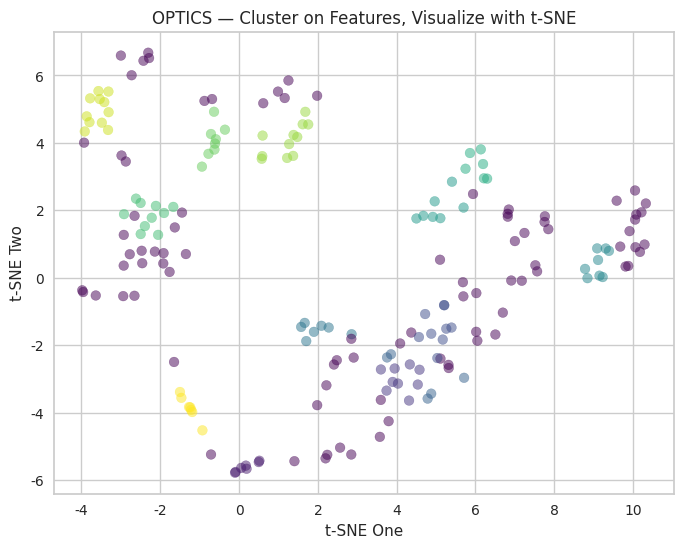

In [102]:
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler

data_optics = df.copy()  # already preprocessed
# Cluster on scaled original features
X_scaled = data_optics.copy()
optics = OPTICS(eps=0.5, min_samples=5)
labels = optics.fit_predict(X_scaled)
# Visualize with t-SNE only
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
tsne_result_optics = tsne.fit_transform(X_scaled)
data_optics['tsne-one'] = tsne_result_optics[:, 0]
data_optics['tsne-two'] = tsne_result_optics[:, 1]
data_optics['cluster'] = labels
plt.figure(figsize=(8,6))
plt.scatter(data_optics['tsne-one'], data_optics['tsne-two'], alpha=0.5, c=data_optics['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('OPTICS — Cluster on Features, Visualize with t-SNE')
plt.show()

In [103]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def evaluate_clustering(predicted_labels, data):
    # Filter out noise points (labeled as -1) for silhouette score calculation
    if -1 in predicted_labels:
        non_noise_indices = predicted_labels != -1
        if np.sum(non_noise_indices) > 1: # Silhouette score requires at least 2 labels
            silhouette = silhouette_score(data[non_noise_indices], predicted_labels[non_noise_indices])
        else:
            silhouette = -1 # Not enough points to calculate
    else:
        silhouette = silhouette_score(data, predicted_labels)
    
    chs = calinski_harabasz_score(data, predicted_labels)
    return silhouette, chs

# Evaluate K-Medoids
kmedoids_scores = evaluate_clustering(data_kmedoids['kmedoids_cluster'].values, data_kmedoids.drop(columns=['tsne-one', 'tsne-two', 'kmedoids_cluster']))

# Evaluate KMeans
kmeans_scores = evaluate_clustering(data_kmeans['cluster'].values, data_kmeans.drop(columns=['tsne-one', 'tsne-two', 'cluster']))

# Evaluate HDBSCAN
hdbscan_scores = evaluate_clustering(data_hdbscan['cluster'].values, data_hdbscan.drop(columns=['tsne-one', 'tsne-two', 'cluster']))

# Evaluate GMM
gmm_scores = evaluate_clustering(data_gmm['cluster'].values, data_gmm.drop(columns=['tsne-one', 'tsne-two', 'cluster']))

# Evaluate OPTICS
optics_scores = evaluate_clustering(data_optics['cluster'].values, data_optics.drop(columns=['tsne-one', 'tsne-two', 'cluster']))

print("K-Medoids Scores (Silhouette, Calinski-Harabasz):", kmedoids_scores)
print("KMeans Scores (Silhouette, Calinski-Harabasz):", kmeans_scores)
print("HDBSCAN Scores (Silhouette, Calinski-Harabasz):", hdbscan_scores)
print("GMM Scores (Silhouette, Calinski-Harabasz):", gmm_scores)
print("OPTICS Scores (Silhouette, Calinski-Harabasz):", optics_scores)

K-Medoids Scores (Silhouette, Calinski-Harabasz): (0.33163693818076606, 72.67927998125721)
KMeans Scores (Silhouette, Calinski-Harabasz): (0.37587037616210206, 95.53544664956043)
HDBSCAN Scores (Silhouette, Calinski-Harabasz): (0.31107332753107225, 29.236673596162763)
GMM Scores (Silhouette, Calinski-Harabasz): (0.2997438609826489, 73.00463115409869)
OPTICS Scores (Silhouette, Calinski-Harabasz): (0.5750306714162872, 16.148838648770553)
